# Results exploration and plots

## Setup

In [1]:
## append ../scripts to path
import os
import sys

# Only append if not already in path
project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
if not os.path.join(project_dir, "workflow/scripts") in sys.path:
    sys.path.append(os.path.join(project_dir, "workflow/scripts"))
print(f"Project directory: {project_dir}")

# Create figures folder if it does not exist
if not os.path.exists(os.path.join(project_dir, "workflow/notebooks/figures")):
    os.makedirs(os.path.join(project_dir, "workflow/notebooks/figures"))

Project directory: /home/bobby/projects/pci-pmi-2030-targets


In [2]:
import logging
logger = logging.getLogger(__name__)
import pypsa
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import yaml
import cartopy.crs as ccrs

In [3]:
# Additional functions from commons
from common import add_carrier_groups, fill_missing_carriers

In [4]:
configfile = str(project_dir) + "/config/config.yaml"
config = yaml.safe_load(open(configfile))

plottingfile = str(project_dir) + "/config/plotting.yaml"
plotting = yaml.safe_load(open(plottingfile))

prefix = config["run"]["prefix"]
scenarios = config["run"]["name"]
print(f"Prefix: {prefix}")
print(f"Scenarios: {scenarios}")

# Overwrite scenarios
scenarios = ["baseline", "baseline_extended", "scenario_a_targets_no_pipelines", "scenario_b_no_targets_no_pipelines", "targets_greenfield_pipelines"]

Prefix: 2030-targets-updated
Scenarios: ['baseline', 'baseline_extended', 'scenario_a_targets_no_pipelines', 'scenario_b_no_targets_no_pipelines', 'scenario_b_no_targets_no_pipelines_smr_0.5_capture_rate', 'targets_greenfield_pipelines', 'baseline--5mth2', 'baseline_extended--5mth2', 'scenario_a_targets_no_pipelines--5mth2', 'targets_greenfield_pipelines--5mth2', 'baseline--gaspipeline_retrofit', 'baseline_extended--gaspipeline_retrofit', 'scenario_a_targets_no_pipelines--gaspipeline_retrofit', 'scenario_b_no_targets_no_pipelines--gaspipeline_retrofit', 'targets_greenfield_pipelines--gaspipeline_retrofit']


In [5]:
# iterate through all scenarios and store all pypsa networks in a dictionary with scenarios as keys
networks = {}
for scenario in scenarios:
    print("")
    print(f"Loading network for scenario {scenario}")
    n_path = project_dir + "/results/" + prefix+ "/"+scenario+"/postnetworks/base_s_90_lv1.05___2030.nc"
    networks[scenario] = pypsa.Network(n_path)

    # Drop carriers = "none"
    networks[scenario].carriers.drop("none",inplace=True)

    # Fill missing carriers
    fill_missing_carriers(networks[scenario])

    # Add carrier groups
    add_carrier_groups(networks[scenario], plotting)    


Loading network for scenario baseline


INFO:pypsa.io:Imported network base_s_90_lv1.05___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores



Loading network for scenario baseline_extended


INFO:pypsa.io:Imported network base_s_90_lv1.05___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores



Loading network for scenario scenario_a_targets_no_pipelines


INFO:pypsa.io:Imported network base_s_90_lv1.05___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores



Loading network for scenario scenario_b_no_targets_no_pipelines


INFO:pypsa.io:Imported network base_s_90_lv1.05___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores



Loading network for scenario targets_greenfield_pipelines


INFO:pypsa.io:Imported network base_s_90_lv1.05___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


## PCI/PMI projects

In [6]:
regions_onshore = gpd.read_file("data/resources/regions_onshore_base_s_90.geojson")

links_hydrogen_pipeline = gpd.read_file("data/resources/pci-pmi-projects/cleaned/links_hydrogen_pipeline.geojson")
links_co2_pipeline = gpd.read_file("data/resources/pci-pmi-projects/cleaned/links_co2_pipeline.geojson")

stores_co2 = gpd.read_file("data/resources/pci-pmi-projects/cleaned/stores_co2.geojson")
stores_hydrogen = gpd.read_file("data/resources/pci-pmi-projects/cleaned/stores_hydrogen.geojson")

/tmp/ipykernel_68081/2581600724.py:69: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



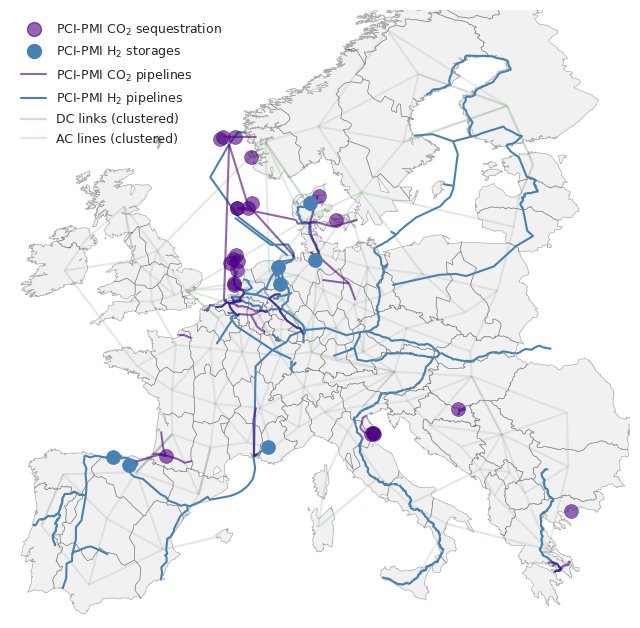

In [28]:
crs = ccrs.EqualEarth()
titlesize = 11
fontsize = 9

color_hydrogen = "steelblue"
color_co2 = "indigo"

fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': crs})

# Add regions
regions_onshore.to_crs(crs.proj4_init).plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.3)

n = networks[scenarios[0]].copy()
n.links = n.links[n.links.carrier=="DC"]
n.plot(ax=ax, bus_sizes=0, link_widths=1.5, line_widths=1.5, line_alpha=0.15, link_alpha=0.15, color_geomap=False, line_colors="grey", link_colors="darkseagreen")

# Add hydrogen pipelines
links_hydrogen_pipeline.to_crs(crs.proj4_init).plot(ax=ax, color=color_hydrogen, linewidth=1.5, alpha=1, zorder=10)

# Add CO2 pipelines
links_co2_pipeline.to_crs(crs.proj4_init).plot(ax=ax, color=color_co2, linewidth=1.5, alpha=0.6, zorder=10)

# Add stores
stores_co2.to_crs(crs.proj4_init).plot(ax=ax, color=color_co2, edgecolor=None, linewidth=0.5, alpha=0.6, zorder=20, markersize=100)
stores_hydrogen.to_crs(crs.proj4_init).plot(ax=ax, color=color_hydrogen, edgecolor=None, linewidth=0.5, alpha=1, zorder=20, markersize=100)

# Add legend
# Create a legend for the pipelines
legend_ac_lines = plt.Line2D([0], [0], color="grey", linewidth=1.7, alpha=0.3)
legend_dc_links = plt.Line2D([0], [0], color="darkseagreen", linewidth=1.7, alpha=0.3)
legend_links_hydrogen = plt.Line2D([0], [0], color=color_hydrogen, linewidth=1.5, alpha=1)
legend_links_co2 = plt.Line2D([0], [0], color=color_co2, linewidth=1.5, alpha=0.6)
legend_stores_hydrogen = plt.Line2D([0], [0], marker="o", linewidth=0, color=color_hydrogen, markersize=10, alpha=1)
legend_stores_co2 = plt.Line2D([0], [0], marker="o", linewidth=0, color=color_co2, markersize=10, alpha=0.6)

name_ac_lines = "AC lines (clustered)"
name_dc_links = "DC links (clustered)"
name_links_hydrogen = "PCI-PMI H$_2$ pipelines"
name_links_co2 = "PCI-PMI CO$_2$ pipelines"
name_stores_hydrogen = "PCI-PMI H$_2$ storages"
name_stores_co2 = "PCI-PMI CO$_2$ sequestration"

# Add legend with border set to none
ax.legend(
    [
        legend_stores_co2,
        legend_stores_hydrogen, 
        legend_links_co2, 
        legend_links_hydrogen, 
        legend_ac_lines, 
        legend_dc_links,
    ], 
    [
        name_stores_co2,
        name_stores_hydrogen, 
        name_links_co2, 
        name_links_hydrogen, 
        name_dc_links,
        name_ac_lines,        
    ], 
    loc="upper left", fontsize=fontsize, frameon=False
)
# Add title
# ax.set_title("Clustered high-voltage grid and PCI-PMI CO$_2$-H$_2$ infrastructure", fontsize=titlesize)

# Save figure
fig.savefig("figures/pci_pmi_projects_map.pdf", bbox_inches="tight")

fig.show()

## Model results

In [8]:
df_overview = pd.DataFrame(columns=["objective_bnEUR"])
for scenario in scenarios:
    n = networks[scenario]
    # Objective
    df_overview.loc[scenario] = round(n.objective/1e9,1)

    # CO2 sequestered
    idx_co2_sequestered = n.stores[n.stores.carrier == "co2 sequestered"].index
    co2_sequestered = n.stores_t.e.loc[n.snapshots[-1], idx_co2_sequestered].sum()
    df_overview.loc[scenario, "co2_sequestered_Mt"] = round(co2_sequestered/1e6,1)

    # Electrolysers installed
    idx_electrolysers = n.links[n.links.carrier == "H2 Electrolysis"].index
    electrolysers_installed = n.links.p_nom_opt.loc[idx_electrolysers].sum()
    df_overview.loc[scenario, "electrolysers_installed_GW"] = round(electrolysers_installed/1e3,1)

    # Hydrogen produced
    idx_electrolysers = n.links[n.links.carrier == "H2 Electrolysis"].index
    h2_produced_mwh = (n.links_t.p1.loc[:,idx_electrolysers].T.sum()*n.snapshot_weightings["generators"]).sum()*(-1)
    df_overview.loc[scenario, "h2_produced_TWh"] = round(h2_produced_mwh/1e6,1)
    h2_produced_t = h2_produced_mwh / 33.33 # 33.33 MWh/t
    df_overview.loc[scenario, "h2_produced_Mt"] = round(h2_produced_t/1e6,1)

    # Electrolyser FLH
    idx_electrolysers = n.links[n.links.carrier == "H2 Electrolysis"].index
    electrolysers_flh = h2_produced_mwh / electrolysers_installed
    df_overview.loc[scenario, "electrolysers_flh"] = round(electrolysers_flh,1)

    # Total system costs
    system_costs = n.statistics.capex().sum() + n.statistics.opex().sum()
    df_overview.loc[scenario, "system_costs_bnEUR"] = round(system_costs/1e9,1)

    # System costs without installed capacities
    system_costs_no_capacities = n.statistics.capex().sum() + n.statistics.opex().sum() - n.statistics.installed_capex().sum()
    df_overview.loc[scenario, "system_costs_w/o_installed_bnEUR"] = round(system_costs_no_capacities/1e9,1)

    # OPEX
    opex = n.statistics.opex().sum()
    df_overview.loc[scenario, "opex_bnEUR"] = round(opex/1e9,1)

df_overview = df_overview.T
df_overview

baseline  baseline_extended  \
objective_bnEUR                      600.5              599.4   
co2_sequestered_Mt                    50.0               50.0   
electrolysers_installed_GW            71.7               72.2   
h2_produced_TWh                      333.3              333.3   
h2_produced_Mt                        10.0               10.0   
electrolysers_flh                   4650.0             4613.8   
system_costs_bnEUR                   813.0              811.9   
system_costs_w/o_installed_bnEUR     600.5              599.4   
opex_bnEUR                           363.2              363.5   

                                  scenario_a_targets_no_pipelines  \
objective_bnEUR                                             606.4   
co2_sequestered_Mt                                           50.0   
electrolysers_installed_GW                                   69.1   
h2_produced_TWh                                             333.3   
h2_produced_Mt                                               10.0   
electrolysers_flh                                          4821.4   
system_costs_bnEUR                                          782.9   
system_costs_w/o_installed_bnEUR                            606.4   
opex_bnEUR                                                  364.0   

                                  scenario_b_no_targets_no_pipelines  \
objective_bnEUR                                                582.2   
co2_sequestered_Mt                                              28.2   
electrolysers_installed_GW                                       0.0   
h2_produced_TWh                                                  0.0   
h2_produced_Mt                                                   0.0   
electrolysers_flh                                             2052.9   
system_costs_bnEUR                                             758.6   
system_costs_w/o_installed_bnEUR                               582.2   
opex_bnEUR                                                     362.2   

                                  targets_greenfield_pipelines  
objective_bnEUR                                          602.0  
co2_sequestered_Mt                                        50.0  
electrolysers_installed_GW                                73.1  
h2_produced_TWh                                          333.3  
h2_produced_Mt                                            10.0  
electrolysers_flh                                       4561.8  
system_costs_bnEUR                                       778.4  
system_costs_w/o_installed_bnEUR                         602.0  
opex_bnEUR                                               363.8

## Plots

### System costs

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

alpha = 1
region_alpha = 0.8

df_system_costs = {}

for scenario, n in networks.items():
    capex = n.statistics.capex(nice_names=False)
    opex = n.statistics.opex(aggregate_time="sum", nice_names=False)

    costs = capex.add(opex, fill_value=0)
    costs = costs.droplevel(0)[lambda x: x > 0]
    costs = costs.groupby(costs.index).sum()

    key = n.meta["wildcards"]["run"]
    df_system_costs[key] = costs

df_system_costs = pd.concat(df_system_costs, axis=1)
df_system_costs.fillna(0, inplace=True)

groups = networks[scenarios[0]].carriers.group
group_dict = dict(zip(groups.index, groups))
grouped_system_costs = df_system_costs.groupby(group_dict).sum()

# add column color
grouped_system_costs["color"] = grouped_system_costs.index.map(lambda x: plotting["plotting"]["technology_group_colors"][x])

grouped_system_costs

baseline  baseline_extended  \
carrier                                                          
Battery Infrastructure         4.218130e+08       4.205748e+08   
Bioenergy                      3.841486e+10       3.834378e+10   
Boiler                         5.057642e+10       5.057923e+10   
CO$_2$ Infrastructure          2.846452e+10       2.839885e+10   
Carbon Capt. at Point Sources  4.060956e+09       3.851332e+09   
Coal                           4.812508e+09       4.033179e+09   
DAC                            1.798770e+04       1.232527e+04   
Electricity Grid               3.997562e+10       4.001426e+10   
Electrolysis                   1.353182e+10       1.363802e+10   
Fischer-Tropsch                8.403548e+08       5.986984e+08   
Gas Infrastructure             1.165305e+11       1.159989e+11   
H$_2$ Infrastructure           7.397226e+09       7.479085e+09   
Heat Pump                      1.138501e+10       1.128365e+10   
Hydro and RoR                  4.344407e+10       4.344402e+10   
Methanation                    2.875276e+07       3.160399e+07   
Methanol                       4.430204e+07       4.403590e+07   
Methanolisation                1.904358e+09       1.905656e+09   
Nuclear                        9.278630e+10       9.278087e+10   
Offshore Wind                  3.998715e+10       3.849727e+10   
Oil                            2.295845e+11       2.305427e+11   
Onshore Wind                   4.101051e+10       4.200391e+10   
Other                          2.021101e+09       2.017180e+09   
Resistive Heater               2.042069e+09       2.051414e+09   
Shipping                       1.649919e+06       1.649919e+06   
Solar                          4.378076e+10       4.391479e+10   

                               scenario_a_targets_no_pipelines  \
carrier                                                          
Battery Infrastructure                            8.659080e+08   
Bioenergy                                         3.921809e+10   
Boiler                                            5.038343e+10   
CO$_2$ Infrastructure                             5.634290e+08   
Carbon Capt. at Point Sources                     5.956796e+09   
Coal                                              4.874981e+09   
DAC                                               6.531403e+08   
Electricity Grid                                  3.913852e+10   
Electrolysis                                      1.305119e+10   
Fischer-Tropsch                                   1.099613e+09   
Gas Infrastructure                                1.164873e+11   
H$_2$ Infrastructure                              5.384651e+08   
Heat Pump                                         1.313866e+10   
Hydro and RoR                                     4.344409e+10   
Methanation                                       5.424985e+03   
Methanol                                          2.517338e+07   
Methanolisation                                   1.820567e+09   
Nuclear                                           9.275293e+10   
Offshore Wind                                     4.162691e+10   
Oil                                               2.286274e+11   
Onshore Wind                                      3.888687e+10   
Other                                             2.091850e+09   
Resistive Heater                                  2.040721e+09   
Shipping                                          1.552509e+06   
Solar                                             4.564520e+10   

                               scenario_b_no_targets_no_pipelines  \
carrier                                                             
Battery Infrastructure                               1.492838e+09   
Bioenergy                                            4.019416e+10   
Boiler                                               4.983856e+10   
CO$_2$ Infrastructure                                2.849035e+08   
Carbon Capt. at Point Sources                        3.

In [12]:
# Whats inside other?
# df_system_costs.loc[list(set(groups[groups.values=="Other"].index).intersection(set(df_system_costs.index)))]

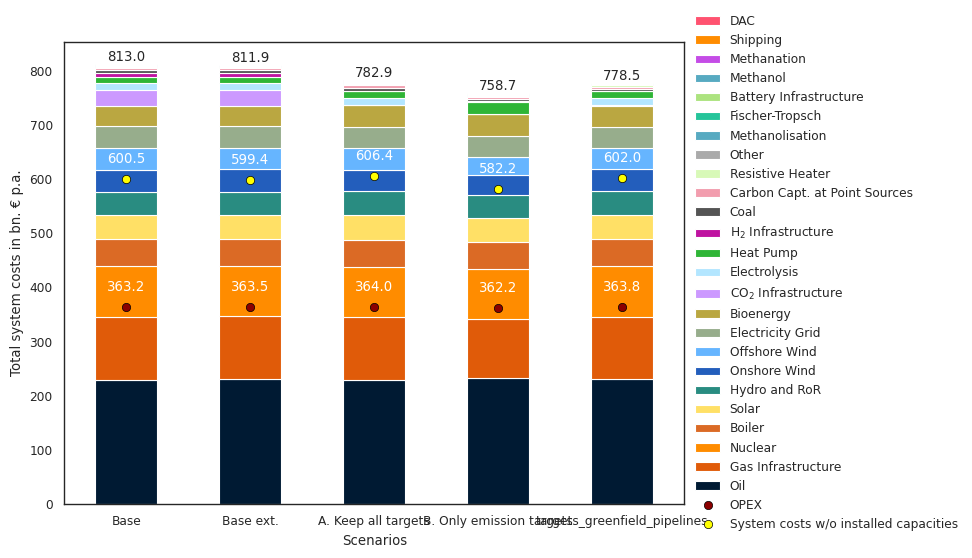

In [10]:
# Stacked bar plot
norm = 1e9
unit = "bn. € p.a."
colors = plotting["plotting"]["technology_group_colors"]
rename_scenarios = {
    "baseline": "Base",
    "baseline_extended": "Base ext.",
    "scenario_a_targets_no_pipelines": "A. Keep all targets",
    "scenario_b_no_targets_no_pipelines": "B. Only emission targets"
}

# Apply Seaborn style
sns.set_style("white")  # You can choose 'whitegrid', 'darkgrid', 'white', 'dark', or 'ticks'
sns.set_context("paper")  # Options: 'paper', 'notebook', 'talk', 'poster'
plt.rcParams['font.family'] = 'sans-serif'

plot_df = grouped_system_costs.sort_values(by="baseline", ascending=False).drop(columns="color").div(norm)
plot_df.rename(columns=rename_scenarios, inplace=True)

# Assuming 'grouped' is your DataFrame and 'colors' is your list of colors
ax = plot_df.T.plot.bar(stacked=True, color=colors, figsize=(8, 6))

# Add sum of total system costs on top of bars 
for i in range(len(plot_df.columns)):
    ax.text(i, plot_df.iloc[:,i].sum(), f"{round(plot_df.iloc[:,i].sum(),1)}", ha='center', va='bottom')

# Add total sum
max_value = plot_df.sum().max()

# Plot settings
ax.set_title("")
ax.set_xlabel("Scenarios")
ax.set_ylabel(f"Total system costs in {unit}")
ax.set_ylim(0, max_value*1.05)
# Rotate x-axis labels
ax.set_xticks(range(len(plot_df.columns)))
ax.set_xticklabels(plot_df.columns, rotation=0)

# Overlay system costs without installed capacities
df_overview.rename(columns=rename_scenarios).loc["system_costs_w/o_installed_bnEUR"].mul(1e9).div(norm).plot(
    ax=ax, marker="o", linestyle="", color="yellow", 
    markeredgecolor="black", markeredgewidth=0.5, markersize=6,
    label="System costs w/o installed capacities",
    zorder = 5  # Higher zorder to appear on top
)
# Add value on top
for i, value in enumerate(df_overview.loc["system_costs_w/o_installed_bnEUR"]):
    ax.text(i, value+24, f"{round(value,1)}", ha='center', va='bottom', color="white", )

# OPEX
df_overview.rename(columns=rename_scenarios).loc["opex_bnEUR"].mul(1e9).div(norm).plot(
    ax=ax, marker="o", linestyle="", color="darkred", 
    markeredgecolor="black", markeredgewidth=0.5, markersize=6,
    label="OPEX",
    zorder=5  # Higher zorder to appear on top
)
# Add value on top
for i, value in enumerate(df_overview.loc["opex_bnEUR"]):
    ax.text(i, value+24, f"{round(value,1)}", ha='center', va='bottom', color="white", )

# Legend, reverse order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.savefig("figures/system_costs.pdf", bbox_inches='tight')
plt.show()

In [15]:
scenarios

['baseline',
 'baseline_extended',
 'scenario_a_targets_no_pipelines',
 'scenario_b_no_targets_no_pipelines',
 'targets_greenfield_pipelines']

In [16]:
n0 = networks["scenario_b_no_targets_no_pipelines"]

In [17]:
n0.statistics.energy_balance(bus_carrier="methanol")

component  carrier            bus_carrier
Link       industry methanol  methanol      -8.750000e+06
           shipping methanol  methanol      -1.508909e+08
           methanolisation    methanol       1.596409e+08
dtype: float64

In [17]:
scenarios[3]

'scenario_b_no_targets_no_pipelines'

In [25]:
n.statistics.energy_balance(bus_carrier="methanol")

component  carrier            bus_carrier
Link       industry methanol  methanol      -8.750000e+06
           shipping methanol  methanol      -1.508909e+08
           methanolisation    methanol       1.596409e+08
dtype: float64

In [20]:
n = networks[scenarios[3]]

In [24]:
n.statistics.market_value(bus_carrier="H2")

component  carrier        
Link       Fischer-Tropsch            NaN
           H2 Electrolysis      63.970972
           H2 Fuel Cell               NaN
           SMR                  66.711101
           SMR CC               55.415145
           Sabatier                   NaN
           methanolisation            NaN
Load       H2 for industry   -4585.355489
Store      H2 Store              5.722284
dtype: float64

In [19]:
networks[scenarios[3]].statistics.energy_balance(bus_carrier="co2")


component  carrier                             bus_carrier
Link       process emissions                   co2            1.968533e+08
           process emissions CC                co2            5.696748e+05
           urban central gas CHP               co2            5.850492e+07
           urban central gas CHP CC            co2            9.916640e+00
           urban central solid biomass CHP CC  co2           -4.321869e+02
           DAC                                 co2           -7.695826e+01
           Open-Cycle Gas                      co2            4.977673e+06
           SMR                                 co2            2.339418e+07
           SMR CC                              co2            5.448553e+06
           agriculture machinery oil           co2            2.644213e+07
           biogas to gas                       co2           -1.292665e+07
           coal for industry                   co2            1.146064e+08
           gas for industry              

In [29]:
sorted(n.links.carrier.unique())

['BEV charger',
 'DAC',
 'DC',
 'Fischer-Tropsch',
 'H2 Electrolysis',
 'H2 Fuel Cell',
 'OCGT',
 'SMR',
 'SMR CC',
 'Sabatier',
 'V2G',
 'agriculture machinery oil',
 'battery charger',
 'battery discharger',
 'biogas to gas',
 'co2 sequestered',
 'coal for industry',
 'electricity distribution grid',
 'gas for industry',
 'gas for industry CC',
 'gas pipeline',
 'gas pipeline new',
 'home battery charger',
 'home battery discharger',
 'industry methanol',
 'kerosene for aviation',
 'land transport oil',
 'methanolisation',
 'naphtha for industry',
 'oil refining',
 'process emissions',
 'process emissions CC',
 'rural air heat pump',
 'rural biomass boiler',
 'rural gas boiler',
 'rural ground heat pump',
 'rural resistive heater',
 'rural water tanks charger',
 'rural water tanks discharger',
 'shipping methanol',
 'shipping oil',
 'solid biomass for industry',
 'solid biomass for industry CC',
 'unsustainable bioliquids',
 'urban central air heat pump',
 'urban central gas CHP',
 '

In [41]:
n.links[n.links.carrier=="SMR CC"].efficiency3

Link
AL0 0 SMR CC    0.1782
AT0 0 SMR CC    0.1782
BA0 0 SMR CC    0.1782
BE0 0 SMR CC    0.1782
BE0 1 SMR CC    0.1782
                 ...  
SE1 1 SMR CC    0.1782
SE1 2 SMR CC    0.1782
SI0 0 SMR CC    0.1782
SK0 0 SMR CC    0.1782
XK0 0 SMR CC    0.1782
Name: efficiency3, Length: 90, dtype: float64

In [37]:
n.links[n.links.carrier=="SMR CC"][["bus0", "bus1", "bus2", "bus3"]]

bus0      bus1            bus2              bus3
Link                                                               
AL0 0 SMR CC  AL0 0 gas  AL0 0 H2  co2 atmosphere  AL0 0 co2 stored
AT0 0 SMR CC  AT0 0 gas  AT0 0 H2  co2 atmosphere  AT0 0 co2 stored
BA0 0 SMR CC  BA0 0 gas  BA0 0 H2  co2 atmosphere  BA0 0 co2 stored
BE0 0 SMR CC  BE0 0 gas  BE0 0 H2  co2 atmosphere  BE0 0 co2 stored
BE0 1 SMR CC  BE0 1 gas  BE0 1 H2  co2 atmosphere  BE0 1 co2 stored
...                 ...       ...             ...               ...
SE1 1 SMR CC  SE1 1 gas  SE1 1 H2  co2 atmosphere  SE1 1 co2 stored
SE1 2 SMR CC  SE1 2 gas  SE1 2 H2  co2 atmosphere  SE1 2 co2 stored
SI0 0 SMR CC  SI0 0 gas  SI0 0 H2  co2 atmosphere  SI0 0 co2 stored
SK0 0 SMR CC  SK0 0 gas  SK0 0 H2  co2 atmosphere  SK0 0 co2 stored
XK0 0 SMR CC  XK0 0 gas  XK0 0 H2  co2 atmosphere  XK0 0 co2 stored

[90 rows x 4 columns]

In [59]:
links_hydrogen_pipeline[["geometry", "build_year"]].explore()

In [ ]:
# n.statistics.withdrawal(bus_carrier="oil")
# n.statistics.sppply(bus_carrier="oil")

component  carrier                  
Link       agriculture machinery oil    1.028476e+08
           kerosene for aviation        7.439070e+08
           land transport oil           2.210376e+09
           naphtha for industry         7.769400e+08
           shipping oil                 4.048906e+08
Store      oil                          1.008664e+02
dtype: float64

In [ ]:
n.stores[n.stores.carrier=="co2 sequestered"].

bus type          carrier  e_nom  \
Store                                                                       
AL0 0 co2 sequestered  AL0 0 co2 sequestered       co2 sequestered    0.0   
AT0 0 co2 sequestered  AT0 0 co2 sequestered       co2 sequestered    0.0   
BA0 0 co2 sequestered  BA0 0 co2 sequestered       co2 sequestered    0.0   
BE0 0 co2 sequestered  BE0 0 co2 sequestered       co2 sequestered    0.0   
BE0 1 co2 sequestered  BE0 1 co2 sequestered       co2 sequestered    0.0   
...                                      ...  ...              ...    ...   
SE1 1 co2 sequestered  SE1 1 co2 sequestered       co2 sequestered    0.0   
SE1 2 co2 sequestered  SE1 2 co2 sequestered       co2 sequestered    0.0   
SI0 0 co2 sequestered  SI0 0 co2 sequestered       co2 sequestered    0.0   
SK0 0 co2 sequestered  SK0 0 co2 sequestered       co2 sequestered    0.0   
XK0 0 co2 sequestered  XK0 0 co2 sequestered       co2 sequestered    0.0   

                       e_nom_mod  e_nom_extendable  e_nom_min  e_nom_max  \
Store                                                                      
AL0 0 co2 sequestered        0.0              True        0.0        0.0   
AT0 0 co2 sequestered        0.0              True        0.0        0.0   
BA0 0 co2 sequestered        0.0              True        0.0        0.0   
BE0 0 co2 sequestered        0.0              True        0.0        0.0   
BE0 1 co2 sequestered        0.0              True        0.0        0.0   
...                          ...               ...        ...        ...   
SE1 1 co2 sequestered        0.0              True        0.0        0.0   
SE1 2 co2 sequestered        0.0              True        0.0        0.0   
SI0 0 co2 sequestered        0.0              True        0.0        0.0   
SK0 0 co2 sequestered        0.0              True        0.0        0.0   
XK0 0 co2 sequestered        0.0              True        0.0        0.0   

                       e_min_pu  e_max_pu  ...  marginal_cost  \
Store                                      ...                  
AL0 0 co2 sequestered       0.0       1.0  ...      -0.090291   
AT0 0 co2 sequestered       0.0       1.0  ...      -0.089348   
BA0 0 co2 sequestered       0.0       1.0  ...      -0.090393   
BE0 0 co2 sequestered       0.0       1.0  ...      -0.089580   
BE0 1 co2 sequestered       0.0       1.0  ...      -0.089543   
...                         ...       ...  ...            ...   
SE1 1 co2 sequestered       0.0       1.0  ...      -0.089913   
SE1 2 co2 sequestered       0.0       1.0  ...      -0.090978   
SI0 0 co2 sequestered       0.0       1.0  ...      -0.089489   
SK0 0 co2 sequestered       0.0       1.0  ...      -0.089043   
XK0 0 co2 sequestered       0.0       1.0  ...      -0.089568   

                       marginal_cost_quadratic  marginal_cost_storage  \
Store                                                                   
AL0 0 co2 sequestered                      0.0                    0.0   
AT0 0 co2 sequestered                      0.0                    0.0   
BA0 0 co2 sequestered                      0.0                    0.0   
BE0 0 co2 sequestered                      0.0                    0.0   
BE0 1 co2 sequestered                      0.0                    0.0   
...                                        ...                    ...   
SE1 1 co2 sequestered                      0.0                    0.0   
SE1 2 co2 sequestered                      0.0                    0.0   
SI0 0 co2 sequestered                      0.0                    0.0   
SK0 0 co2 sequestered                      0.0                    0.0   
XK0 0 co2 sequestered                      0.0                    0.0   

                       capital_cost  standing_loss  active  build_year  \
Store                                                                    
AL0 0 co2 sequestered          10.0            0.0    True           0   
AT0 0 co2 sequestered          1

In [13]:
n.statistics.energy_balance(bus_carrier="methanol")

component  carrier            bus_carrier
Link       industry methanol  methanol      -8.750000e+06
           shipping methanol  methanol      -1.508909e+08
           methanolisation    methanol       1.596409e+08
dtype: float64

In [14]:
scenarios

['baseline',
 'baseline_extended',
 'scenario_a_targets_no_pipelines',
 'scenario_b_no_targets_no_pipelines',
 'scenario_b_no_targets_no_pipelines_smr_0.5_capture_rate',
 'targets_greenfield_pipelines',
 'baseline--5mth2',
 'baseline_extended--5mth2',
 'scenario_a_targets_no_pipelines--5mth2',
 'targets_greenfield_pipelines--5mth2',
 'baseline--gaspipeline_retrofit',
 'baseline_extended--gaspipeline_retrofit',
 'scenario_a_targets_no_pipelines--gaspipeline_retrofit',
 'scenario_b_no_targets_no_pipelines--gaspipeline_retrofit',
 'targets_greenfield_pipelines--gaspipeline_retrofit']

In [16]:
n1 = networks['scenario_b_no_targets_no_pipelines']
n2 = networks['scenario_b_no_targets_no_pipelines_smr_0.5_capture_rate']

In [17]:
n1.statistics.energy_balance(bus_carrier="co2 sequestered")

component  carrier          bus_carrier    
Link       co2 sequestered  co2 sequestered    2.820490e+07
Store      co2 sequestered  co2 sequestered   -2.820490e+07
dtype: float64

In [18]:
n2.statistics.energy_balance(bus_carrier="co2 sequestered")

component  carrier          bus_carrier    
Link       co2 sequestered  co2 sequestered    2.143082e+07
Store      co2 sequestered  co2 sequestered   -2.143082e+07
dtype: float64

In [19]:
n0 = networks["baseline"]

In [20]:
n0.links.carrier.unique()

array(['DC', 'co2 sequestered', 'OCGT', 'H2 Electrolysis', 'H2 Fuel Cell',
       'gas pipeline', 'gas pipeline new', 'H2 pipeline',
       'battery charger', 'battery discharger', 'Sabatier', 'SMR CC',
       'SMR', 'BEV charger', 'V2G', 'oil refining', 'land transport oil',
       'urban central air heat pump', 'urban central water tanks charger',
       'urban central water tanks discharger',
       'urban central resistive heater', 'urban central gas boiler',
       'urban central gas CHP', 'urban central gas CHP CC',
       'unsustainable bioliquids', 'biogas to gas',
       'urban central solid biomass CHP',
       'urban central solid biomass CHP CC', 'solid biomass for industry',
       'solid biomass for industry CC', 'gas for industry',
       'gas for industry CC', 'industry methanol', 'methanolisation',
       'shipping methanol', 'shipping oil', 'Fischer-Tropsch',
       'naphtha for industry', 'kerosene for aviation',
       'process emissions', 'process emissions CC', 'c

In [30]:
n0.links[n0.links.carrier=="SMR CC"]

bus0      bus1 type carrier  efficiency  active  \
Link                                                                 
AL0 0 SMR CC  AL0 0 gas  AL0 0 H2       SMR CC        0.69    True   
AT0 0 SMR CC  AT0 0 gas  AT0 0 H2       SMR CC        0.69    True   
BA0 0 SMR CC  BA0 0 gas  BA0 0 H2       SMR CC        0.69    True   
BE0 0 SMR CC  BE0 0 gas  BE0 0 H2       SMR CC        0.69    True   
BE0 1 SMR CC  BE0 1 gas  BE0 1 H2       SMR CC        0.69    True   
...                 ...       ...  ...     ...         ...     ...   
SE1 1 SMR CC  SE1 1 gas  SE1 1 H2       SMR CC        0.69    True   
SE1 2 SMR CC  SE1 2 gas  SE1 2 H2       SMR CC        0.69    True   
SI0 0 SMR CC  SI0 0 gas  SI0 0 H2       SMR CC        0.69    True   
SK0 0 SMR CC  SK0 0 gas  SK0 0 H2       SMR CC        0.69    True   
XK0 0 SMR CC  XK0 0 gas  XK0 0 H2       SMR CC        0.69    True   

              build_year  lifetime  p_nom  p_nom_mod  ...  voltage  location  \
Link                                                  ...                      
AL0 0 SMR CC           0      30.0    0.0        0.0  ...      NaN             
AT0 0 SMR CC           0      30.0    0.0        0.0  ...      NaN             
BA0 0 SMR CC           0      30.0    0.0        0.0  ...      NaN             
BE0 0 SMR CC           0      30.0    0.0        0.0  ...      NaN             
BE0 1 SMR CC           0      30.0    0.0        0.0  ...      NaN             
...                  ...       ...    ...        ...  ...      ...       ...   
SE1 1 SMR CC           0      30.0    0.0        0.0  ...      NaN             
SE1 2 SMR CC           0      30.0    0.0        0.0  ...      NaN             
SI0 0 SMR CC           0      30.0    0.0        0.0  ...      NaN             
SK0 0 SMR CC           0      30.0    0.0        0.0  ...      NaN             
XK0 0 SMR CC           0      30.0    0.0        0.0  ...      NaN             

              length_original  tags  reversed  geometry  under_construction  \
Link                                                                          
AL0 0 SMR CC              0.0           False                           NaN   
AT0 0 SMR CC              0.0           False                           NaN   
BA0 0 SMR CC              0.0           False                           NaN   
BE0 0 SMR CC              0.0           False                           NaN   
BE0 1 SMR CC              0.0           False                           NaN   
...                       ...   ...       ...       ...                 ...   
SE1 1 SMR CC              0.0           False                           NaN   
SE1 2 SMR CC              0.0           False                           NaN   
SI0 0 SMR CC              0.0           False                           NaN   
SK0 0 SMR CC              0.0           False                           NaN   
XK0 0 SMR CC              0.0           False                           NaN   

              underwater_fraction  dc  underground  
Link                                                
AL0 0 SMR CC                  NaN NaN          NaN  
AT0 0 SMR CC                  NaN NaN          NaN  
BA0 0 SMR CC                  NaN NaN          NaN  
BE0 0 SMR CC                  NaN NaN          NaN  
BE0 1 SMR CC                  NaN NaN          NaN  
...                           ...  ..          ...  
SE1 1 SMR CC                  NaN NaN          NaN  
SE1 2 SMR CC                  NaN NaN          NaN  
SI0 0 SMR CC                  NaN NaN          NaN  
SK0 0 SMR CC                  NaN NaN          NaN  
XK0 0 SMR CC                  NaN NaN          NaN  

[90 rows x 50 columns]

In [34]:
n0.links[n0.links.carrier=="process emissions CC"].marginal_cost

Link
AL0 0 process emissions CC    0.010060
AT0 0 process emissions CC    0.009871
BA0 0 process emissions CC    0.010291
BE0 0 process emissions CC    0.010292
BE0 1 process emissions CC    0.009195
                                ...   
SE1 1 process emissions CC    0.009071
SE1 2 process emissions CC    0.009433
SI0 0 process emissions CC    0.010023
SK0 0 process emissions CC    0.010235
XK0 0 process emissions CC    0.009370
Name: marginal_cost, Length: 90, dtype: float64